In [109]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np
import pandas as pd
import seaborn as sns
import shared_utils
from scipy.stats import zscore

# set_option to increase max rows displayed to 200, to see entire df in 1 go/
pd.set_option("display.max_rows", 200)

# function to display df info
def df_peek(df):
    display(type(df), df.shape, df.dtypes, df.sample(2))

## Read in cost per bus data

In [ ]:
# cleaned FTA Grant Award Press Release Data for buses only
fta = pd.read_csv(
    "gs://calitp-analytics-data/data-analyses/bus_procurement_cost/fta_bus_cost_clean.csv"
)

In [ ]:
# cleaned TIRCP Project Tracking Data project tracking sheet
tircp = pd.read_csv(
    "gs://calitp-analytics-data/data-analyses/bus_procurement_cost/tircp_project_bus_only.csv"
)

## Game Plan
- <s>bring in both data sets (FTA Press Release and TIRCP bus data
- <s>FTA data, make sure it only has rows with bus count > 0
- may need to clean up the prop type and bus size type if there are any similar categories (completed at FTA notebook)
- <s>Create shorten data frames for each. include the following columns:
    1. agency name (project_sponsor & grant_recipient)
    2. project title? (project_title)
    3. project award amount (funding and tircp_award_amount($))
    4. bus count (bus_count)
    5. propulsion type (prop_type)
    6. bus size type (bus_size_type)
<br>
<br>
- <s>concat the short dataframes
- <s>start aggregation. sum/count bus count, funding and project #
    * agg by agency name
    * agg by prop type
    * agg by bus size type

- <s>new column for Z-score of `cost_per_bus`
- rerun stats sumamry
- use functions to make charts

## Read in FTA and TIRCP Data

In [ ]:
# peaking into each dataset
data = [fta, tircp]

for x in data:
    display(x.shape, x.columns, x.head(), x.dtypes)

## Dataset cleaning

### drop some columns

In [ ]:
# examine columns
display(fta.columns, tircp.columns)

In [ ]:
fta = fta.drop(
    columns=[
        "Unnamed: 0",
        "area_served",
        "congressional_districts",
        "fta_region",
        "bus/low-no_program",
    ]
)

In [ ]:
tircp = tircp.drop(
    columns=[
        "Unnamed: 0.2",
        "Unnamed: 0.1",
        "Unnamed: 0",
        "award_year",
        "district",
        "county",
        "total_project_cost",
    ]
)

In [ ]:
display(fta.columns, tircp.columns)

### drop zero bus counts from FTA

In [ ]:
fta = fta[fta["bus_count"] > 0]

In [ ]:
# no more '0' values
fta.bus_count.unique()

## Shorten data frames

FTA & TIRCP columns names respecitvely

    1. agency name (project_sponsor & grant_recipient)
    2. project title? (project_title)
    3. project award amount (funding and tircp_award_amount($))
    4. bus count (bus_count)
    5. propulsion type (prop_type)
    6. bus size type (bus_size_type)

In [ ]:
fta_short = fta[
    [
        "project_sponsor",
        "project_title",
        "funding",
        "bus_count",
        "prop_type",
        "bus_size_type",
    ]
]

In [ ]:
len(fta_short) == len(fta)

In [ ]:
tircp_short = tircp[
    [
        "grant_recipient",
        "project_title",
        "tircp_award_amount_($)",
        "bus_count",
        "prop_type",
        "bus_size_type",
    ]
]

In [ ]:
len(tircp_short) == len(tircp)

## rename columns to match eachother

In [ ]:
# list of new column names. to be applied in same order as short df
new_col = [
    "agency_name",
    "project_title",
    "project_award_amount",
    "bus_count",
    "prop_type",
    "bus_size_type",
]

In [ ]:
fta_short.columns = new_col
tircp_short.columns = new_col

In [ ]:
fta_short.columns == tircp_short.columns

In [ ]:
# add new col to identify source
fta_short["source"] = "fta_press_release"
tircp_short["source"] = "tircp_project_tracking"

In [ ]:
display(fta_short.head(), tircp_short.head())

## Concat both dataframes

In [ ]:
concat = pd.concat([fta_short, tircp_short], axis=0).reset_index()

In [ ]:
# checking work
# check len of both data frames and concat, see if they equal eachother
display(
    len(fta_short), len(tircp_short), len(fta_short) + len(tircp_short) == len(concat)
)

In [ ]:
concat.sample(3)

In [ ]:
concat = concat.drop("index", axis=1)

In [ ]:
# concat looks good
# prop_types still look good 
list(concat.prop_type.sort_values().unique())

## Export concat data

In [ ]:
concat.to_csv(
    "gs://calitp-analytics-data/data-analyses/bus_procurement_cost/fta_tircp_concat.csv"
)

## Read in concat data (TIRCP and FTA data)

In [3]:
all_bus = pd.read_csv(
    "gs://calitp-analytics-data/data-analyses/bus_procurement_cost/fta_tircp_concat.csv"
)

## create cost_per_bus_column
on all_bus df

In [4]:
all_bus["cost_per_bus"] = (
    all_bus["project_award_amount"] / all_bus["bus_count"]
).astype("int64")

In [ ]:
df_peek(all_bus)

## Aggregate
To get total funding and bus count
- per agency
- per propulsion type
- per bus size type

In [82]:
## function to agg by X col by project title, award, bus count and cost_per_bus
def bus_aggregate(column, df=all_bus):
    df_agg = (
        df.groupby(column)
        .agg(
            total_project_count=("project_title", "count"),
            total_funds=("project_award_amount", "sum"),
            total_bus_count=("bus_count", "sum"),
            total_cpb=('cost_per_bus', 'sum'),
            
        )
        .reset_index()
    )
    return df_agg

In [83]:
agency_agg = bus_aggregate("agency_name")
prop_agg = bus_aggregate("prop_type")
size_agg = bus_aggregate("bus_size_type")

In [7]:
# list and loop to look at all agg dfs at the same time
agg_list = [agency_agg, prop_agg, size_agg]

for x in agg_list:
    display(df_peek(x))

pandas.core.frame.DataFrame

(127, 5)

agency_name             object
total_project_count      int64
total_funds              int64
total_bus_count        float64
total_cpb                int64
dtype: object

,agency_name,total_project_count,total_funds,total_bus_count,total_cpb
43,Delaware Transit Corporation (DTC),1,8740728,6.0,1456788
100,South Dakota Department of Transportation on b...,1,1276628,9.0,141847


None

pandas.core.frame.DataFrame

(12, 5)

prop_type               object
total_project_count      int64
total_funds              int64
total_bus_count        float64
total_cpb                int64
dtype: object

,prop_type,total_project_count,total_funds,total_bus_count,total_cpb
9,mix (zero and low emission buses),5,76426268,166.0,3027306
7,mix (BEB and FCEB),1,8740728,6.0,1456788


None

pandas.core.frame.DataFrame

(4, 5)

bus_size_type           object
total_project_count      int64
total_funds              int64
total_bus_count        float64
total_cpb                int64
dtype: object

,bus_size_type,total_project_count,total_funds,total_bus_count,total_cpb
1,cutaway,4,32861322,183.0,1198372
3,over-the-road,3,24692000,24.0,3827414


None

## Summary Stats

### Z-score for cost_per_bus 

In [8]:
# add new column for z-score
all_bus["zscore_cost_per_bus"] = zscore(all_bus["cost_per_bus"])

In [ ]:
df_peek(all_bus)

In [26]:
# peek into df, see there are some zscores outside +3
display(
    len(all_bus),
    all_bus.sort_values(by='zscore_cost_per_bus', ascending= True).head(),
)

133

,Unnamed: 0,agency_name,project_title,project_award_amount,bus_count,prop_type,bus_size_type,source,cost_per_bus,zscore_cost_per_bus
95,95,Oregon Department of Transportation on behalf ...,CET's Low Emission Vanpools and Support Vehicles,181250,5.0,low emission (hybrid),not specified,fta_press_release,36250,-0.887972
97,97,Orange County Transportation Authority (OCTA),Bravo! Route 560 Rapid Buses,2320000,40.0,CNG,conventional (40-ft like),tircp_project_tracking,58000,-0.868617
94,94,The Colorado Department of Transportation (CDO...,SMART Vanpool Vehicle Replacement Project,233760,3.0,not specified,not specified,fta_press_release,77920,-0.850890
78,78,Illinois Department of Transportation on behal...,Illinois DOT Statewide Paratransit Vehicle Rep...,12600000,134.0,not specified,cutaway,fta_press_release,94029,-0.836555
77,77,South Carolina Department of Transportation on...,SCDOT Vehicle Replacement Project,15423904,160.0,not specified,not specified,fta_press_release,96399,-0.834446


In [16]:
# remove outliers
# filter df for zscores between -3 and 3
zscore_bus = all_bus[
    (all_bus["zscore_cost_per_bus"] >= -3) & (all_bus["zscore_cost_per_bus"] <= 3)
]

In [17]:
# check work

# 2 rows were dropped
# max and min are withing -3 to 3
display(
    len(zscore_bus),
    zscore_bus.zscore_cost_per_bus.max(),
    zscore_bus.zscore_cost_per_bus.min(),
)

131

2.3732393072982587

-0.8879722054734137

In [18]:
cpb_mean = zscore_bus.cost_per_bus.mean()
cpb_std = zscore_bus.cost_per_bus.std()

## Chart functions 

In [107]:
# distribution curve of cost per bus. no outliers
def dist_curve(df, mean, std, title="Cost Per Bus Distribution", xlabel='"cost per bus, $ million(s)"'):
    sns.histplot(df["cost_per_bus"], kde=True, color="skyblue", bins=20)
    plt.axvline(
        mean, color="red", linestyle="dashed", linewidth=2, label=f"Mean: ${mean:,.2f}"
    )


    plt.axvline(
    mean + std,
    color="green",
    linestyle="dashed",
    linewidth=2,
    label=f"Standard Deviation: ${std:,.2f}",
)
    plt.axvline(mean - std, color="green", linestyle="dashed", linewidth=2)
    plt.axvline(mean + std * 2, color="green", linestyle="dashed", linewidth=2)
    plt.axvline(mean + std * 3, color="green", linestyle="dashed", linewidth=2)

    plt.title(title +' with Mean and Standard Deviation')
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    
    # Turn off scientific notation on x-axis
    plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=False))
    
    plt.legend()
    plt.show()

    return

In [20]:
# chart function
def make_chart(y_col, title, data=zscore_bus,  x_col="agency_name"):
    data.sort_values(by=y_col, ascending=False).head(10).plot(
        x=x_col, y=y_col, kind="bar", color="skyblue"
    )
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    
    plt.ticklabel_format(style='plain', axis='y')
    plt.show()

In [28]:
list(all_bus['prop_type'].unique())

['BEB',
 'CNG',
 'zero-emission bus (not specified)',
 'mix (zero and low emission buses)',
 'FCEB',
 'electric (not specified)',
 'low emission (hybrid)',
 'mix (BEB and FCEB)',
 'mix (low emission)',
 'low emission (propane)',
 'not specified',
 'low emission (ethanol)']

## Summary

In [91]:
# Variables
total_unique_projects = len(all_bus)
total_bus_count = sum(all_bus.bus_count)
total_funding = sum(all_bus.project_award_amount)
min_bus_cost = all_bus.cost_per_bus.min()
max_bus_cost = all_bus.cost_per_bus.max()
max_bus_count = all_bus.bus_count.max()


cpb_mean = zscore_bus.cost_per_bus.mean()
cpb_std = zscore_bus.cost_per_bus.std()

# agency
agency_with_most_bus = all_bus.loc[all_bus["bus_count"].idxmax(), "agency_name"]

# propulsion type
prop_type_name_max_freq = all_bus['prop_type'].value_counts().idxmax()
prop_type_max = all_bus['prop_type'].value_counts().max()

prop_type_name_min_freq = all_bus['prop_type'].value_counts().idxmin()
prop_type_min = all_bus['prop_type'].value_counts().min()

# how many buses do they have? already answered
agency_with_highest_funds = all_bus.loc[
    all_bus["project_award_amount"].idxmax(), "agency_name"
]
# what is the highest amount? already answered
agency_max_cpb = all_bus.loc[all_bus["cost_per_bus"].idxmax(), "agency_name"]
agency_min_cpb = all_bus.loc[all_bus["cost_per_bus"].idxmin(), "agency_name"]
prop_type_max_cpb = all_bus.loc[all_bus["cost_per_bus"].idxmax(), "prop_type"]
prop_type_min_cpb = all_bus.loc[all_bus["cost_per_bus"].idxmin(), "prop_type"]

# Zeb only df and Count of ZEB
zeb_only = all_bus[all_bus['prop_type'].isin(['BEB',
 'zero-emission bus (not specified)',
 'FCEB',
 'electric (not specified)',
 'mix (BEB and FCEB)',
])
]
zeb_count = len(zeb_only.prop_type)

# non-zeb df and Count of non-ZEB
non_zeb_only = all_bus[~all_bus['prop_type'].isin(['BEB',
 'zero-emission bus (not specified)',
 'FCEB',
 'electric (not specified)',
 'mix (BEB and FCEB)',
 'not specified'
])
]
non_zeb_count = len(non_zeb_only.prop_type)

summary = f"""
As of today, data was scraped from mutltiple sources:
    1. FTA Bus and Low- and No-Emission Grant Awards press release (federaly funded, nationwide data)
    2. TIRCP project data (state-funded, California only)
    
Data from DGS usage reports, Georgia and Washington contracts to be analyzed next.

Note, some projects included additional compoments besides bus purchases (chargers, transit facilities, parts, training) which may cause project costs to increase dramaticly, whereas other projects specified only bus purcahses, and some did not include and bus purchases at all.
Additionally, some projects do not accurately or specifically describe the propulsion or bus size type. 

Datasets was filtered to only include data that specificed the number of buses to purchase. The compiled data was aggregated by agencies and a 'cost per_bus' metric was calculated by dividing the total funding the agency received by the total number of buses they specify.

In total:
    - {total_unique_projects} projects with bus purchases were analyzed.
    - ${total_funding:,.2f} was awarded to agencies for projects including bus purchases.
    - {total_bus_count} total buses are to be purchased.
    - The highest awarded dollars per bus for an agency was ${max_bus_cost:,.2f} for a {prop_type_max_cpb}, belonging too {agency_max_cpb}. 
    - The lowest awarded dollars per bus for an agency was ${min_bus_cost:,.2f} for a {prop_type_min_cpb}, belonging too {agency_min_cpb}.

The agency with the most buses specified was {agency_with_most_bus} with {max_bus_count} buses.

Regarding propulsion types:
 Propulsion type values varied wildly amongst the datasets. Values were validated and grouped as best as poissible based on project description or other discrete mentions of propulsion type.
 The following is a summary of propulsion type metrics.
     - The most common propulsion type that was procureded was "{prop_type_name_max_freq}".
     - The number of zero-emission buses procured (electric, battery-electric and fuel-cell electric) is {zeb_count}.
     - the number of non-zero emission buses procured (CNG, hybrids, other alternate fuels) is {non_zeb_count}.
     
 

The following was discovered after removing outliers, :
    - overall the awarded dollars per bus is ${cpb_mean:,.2f}.
    - overal the standard deviation awarded dollars per bus is ${cpb_std:,.2f}. 

Below are charts that summarize the data.
"""

In [ ]:
print(summary)


# Higest awarded funds by agency
make_chart("project_award_amount", "Highest Awarded Funds by Transit Agency")

# highest cost per bus by agency
make_chart("cost_per_bus", "Highest cost per bus by Transit Agency")

# Highest bus count
make_chart("bus_count", "Highest Bus Count by Agency")

# COST PER BUS BY PROP TYPE
# using prop_agg df and 'total_funds'
make_chart("total_funds", "award amount by propulsion type", x_col="prop_type", data=prop_agg)


## Charts
By Agency
- most awarded dollars
- most bus count
- highest cpb
- Most frequent prop_type procured

By prop_type
- most awarded dollars
- most bus count
- highest cpb
- Most frequent prop_type

Just zero emission
(electric, beb, fceb, mix(beb and fceb))
- most awarded dollars
- most bus count
- highest cpb

Stats Curves
- distribution of cpb
- 


In [ ]:
df_peek(all_bus)

### By Agency

In [ ]:
# most awarded dollars by agency
make_chart("project_award_amount", "Most funds awarded by Transit Agency")

In [ ]:
# Highest bus count by agency
make_chart("bus_count", "Most buses procured by Transit Agency")

In [ ]:
# highest cost per bus by agency
make_chart("cost_per_bus", "Highest overall cost per bus (cps) by Transit Agency")

In [ ]:
# most frequent prop_type by agency
prop_type_freq = all_bus.prop_type.value_counts().reset_index()
prop_type_freq.columns = ['prop_type', 'freq']
make_chart('freq', 'Most frequent propulsion type mentioned', x_col ='prop_type', data =prop_type_freq)

### By `prop_type`

In [ ]:
# COST PER BUS BY PROP TYPE
# using prop_agg df and 'total_funds'
make_chart("total_funds", "award amount by propulsion type", x_col="prop_type", data=prop_agg)

In [ ]:
# COST PER BUS BY PROP TYPE
make_chart("total_cpb", "cost per bus by propulsion type", x_col="prop_type", data=prop_agg)

In [ ]:
# COST PER BUS BY PROP TYPE
make_chart("total_bus_count", "cost per bus by propulsion type", x_col="prop_type", data=prop_agg )

## ZEB Only df
`zeb_only`

In [76]:
zeb_only.columns

Index(['Unnamed: 0', 'agency_name', 'project_title', 'project_award_amount',
       'bus_count', 'prop_type', 'bus_size_type', 'source', 'cost_per_bus',
       'zscore_cost_per_bus'],
      dtype='object')

In [85]:
zeb_agg = bus_aggregate('prop_type',df=zeb_only)

In [87]:
zeb_agg.columns

Index(['prop_type', 'total_project_count', 'total_funds', 'total_bus_count',
       'total_cpb'],
      dtype='object')

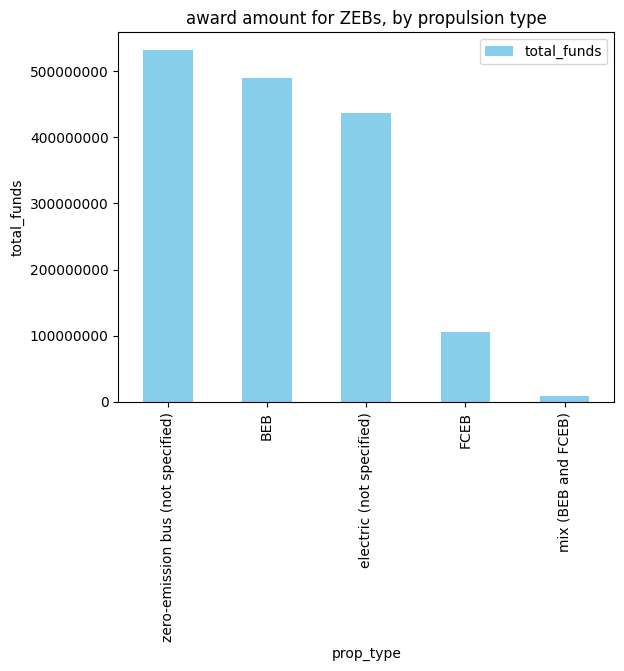

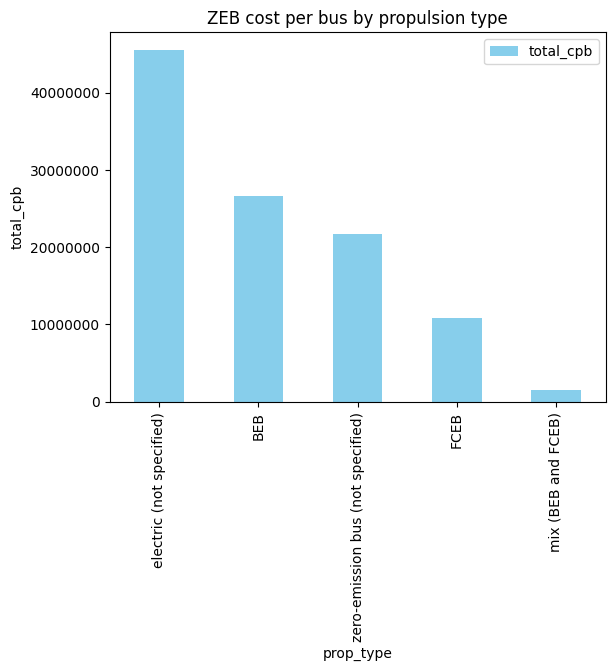

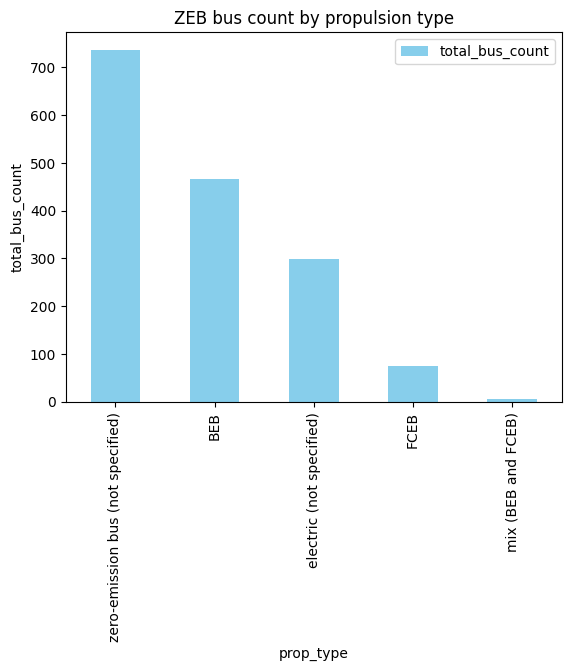

In [95]:
make_chart("total_funds", "award amount for ZEBs, by propulsion type", x_col="prop_type", data=zeb_agg)
make_chart("total_cpb", "ZEB cost per bus by propulsion type", x_col="prop_type", data=zeb_agg)
make_chart("total_bus_count", "ZEB bus count by propulsion type", x_col="prop_type", data=zeb_agg)

## Non ZEB df
`non_zeb_only`

In [ ]:
df_peek(non_zeb_only)

In [93]:
non_zeb_agg = bus_aggregate('prop_type',df=non_zeb_only)

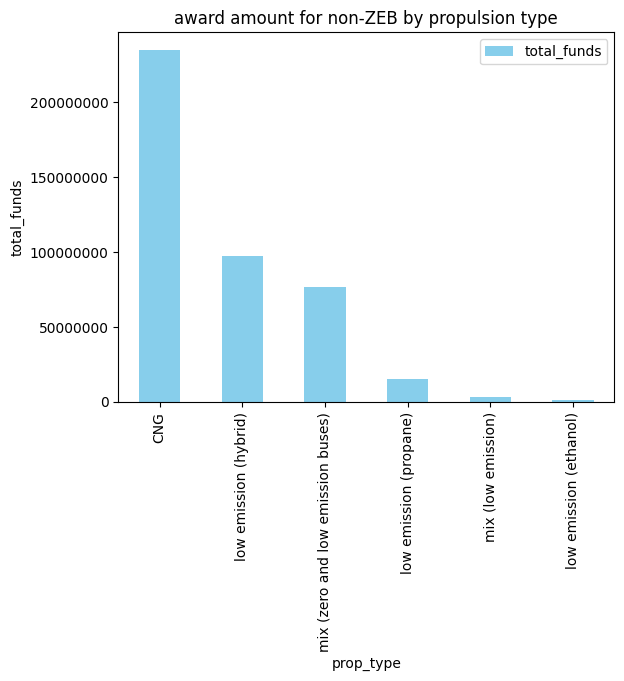

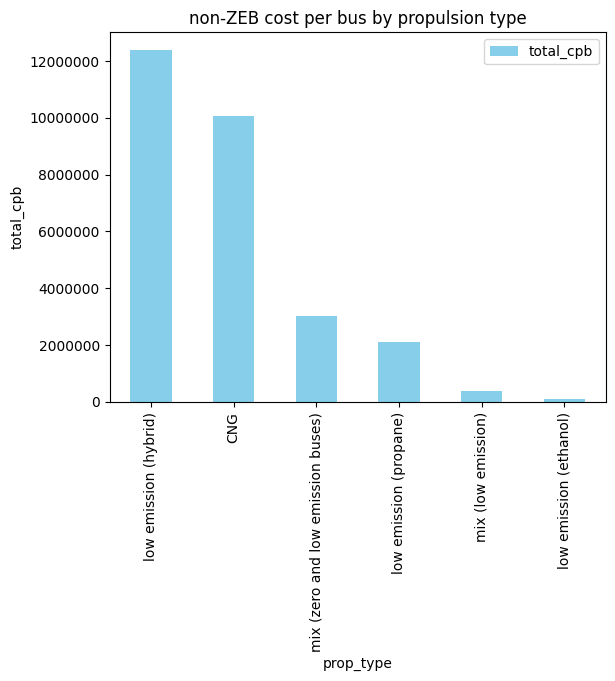

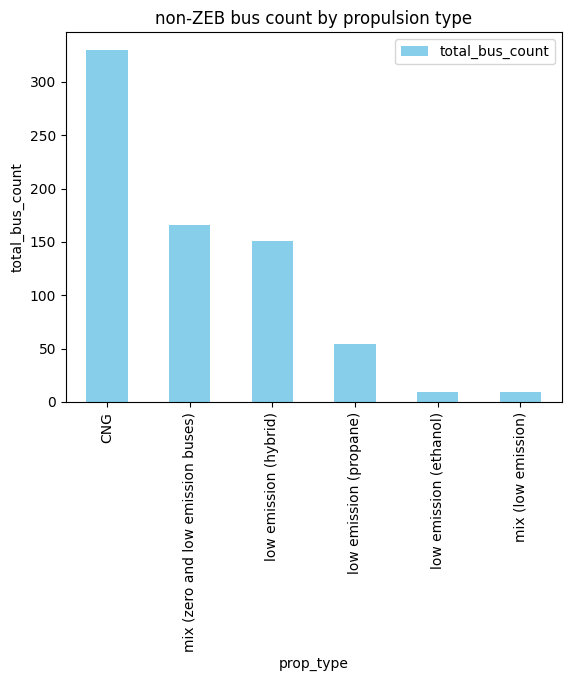

In [96]:
make_chart("total_funds", "award amount for non-ZEB by propulsion type", x_col="prop_type", data=non_zeb_agg)
make_chart("total_cpb", "non-ZEB cost per bus by propulsion type", x_col="prop_type", data=non_zeb_agg)
make_chart("total_bus_count", "non-ZEB bus count by propulsion type", x_col="prop_type", data=non_zeb_agg)

### Stat Curves

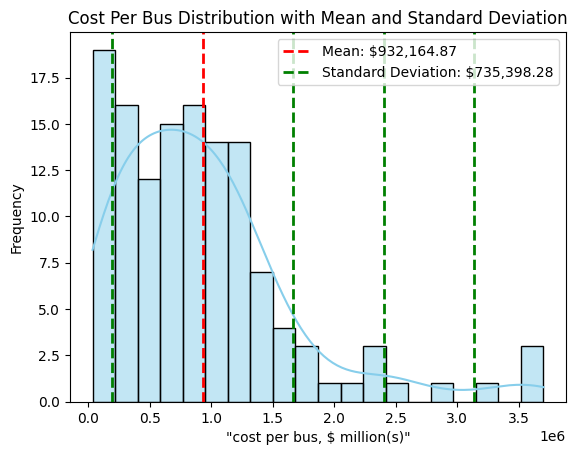

In [110]:
#overall cpb
dist_curve(zscore_bus, cpb_mean, cpb_std)

In [114]:
zeb_only.zscore_cost_per_bus.max()

7.622770280160537

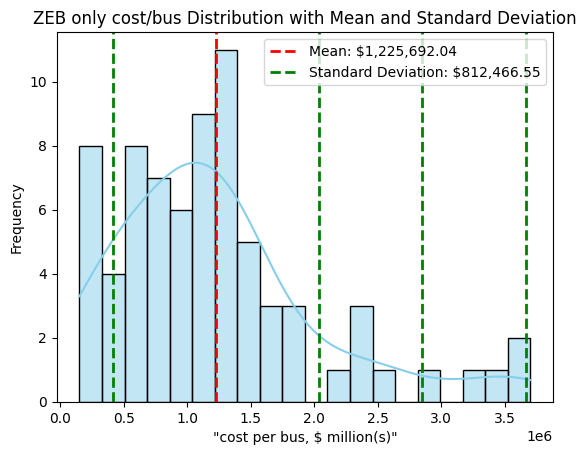

In [117]:
# zeb-only, no outliers
zeb_only_no_outliers = zeb_only[
    (zeb_only["zscore_cost_per_bus"] >= -3) & (zeb_only["zscore_cost_per_bus"] <= 3)
]

# zeb only, no outliers cpb curve
zeb_only_mean = zeb_only_no_outliers.cost_per_bus.mean()
zeb_only_std = zeb_only_no_outliers.cost_per_bus.std()

dist_curve(zeb_only_no_outliers, zeb_only_mean, zeb_only_std, title='ZEB only cost/bus Distribution')


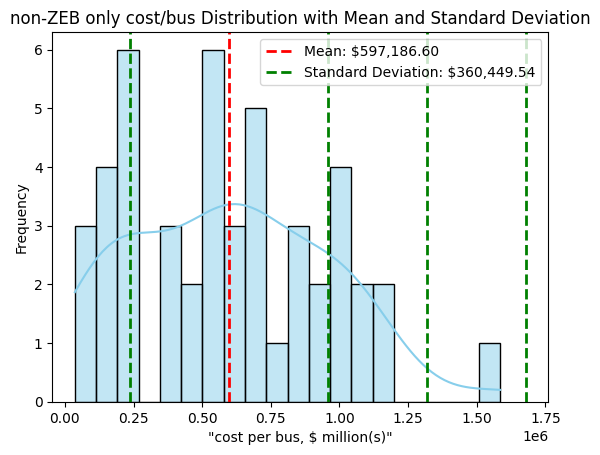

In [106]:
# non-zeb cpb curve
non_zeb_only_mean = non_zeb_only.cost_per_bus.mean()
non_zeb_only_std = non_zeb_only.cost_per_bus.std()

dist_curve(non_zeb_only, non_zeb_only_mean, non_zeb_only_std, title='non-ZEB only cost/bus Distribution')

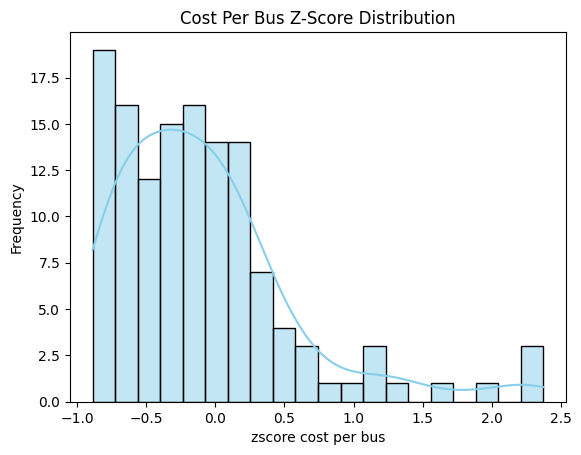

In [24]:
# distribution curve of zscore
sns.histplot(zscore_bus["zscore_cost_per_bus"], kde=True, color="skyblue", bins=20)
plt.title("Cost Per Bus Z-Score Distribution")
plt.xlabel("zscore cost per bus")
plt.ylabel("Frequency")
plt.show()